In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from mvmm.single_view.gaussian_mixture import GaussianMixture
from mvmm.multi_view.LogPenMVMM import LogPenMVMM
from mvmm.multi_view.MVMM import MVMM
from mvmm.multi_view.TwoStage import TwoStage
from mvmm.multi_view.MVMMGridSearch import MVMMGridSearch

from mvmm.multi_view.utils import unit_intval_polyspace

from mvmm.multi_view.toy_data_pi import sample_sparse_Pi
from mvmm.multi_view.toy_data import setup_rand_view_params, sample_gmm

# Sample data from a two view MVMM with a sparse Pi matrix

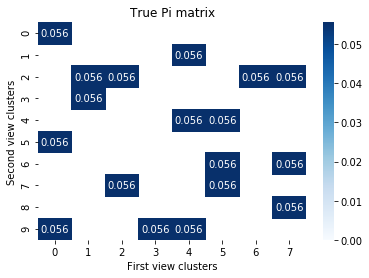

In [7]:
# a sparse matrix with equal entries
Pi_true = sample_sparse_Pi(n_rows_base=10, n_cols_base=10, density=.25, random_state= 849)
n_comp_true = (Pi_true > 0).sum()

# plot Pi
sns.heatmap(Pi_true.T,  # transpose so the first view is on the rows
            annot=True, cmap='Blues', vmin=0,
            mask=Pi_true.T == 0)
plt.xlabel("First view clusters")
plt.ylabel("Second view clusters")
plt.title("True Pi matrix")



# set up cluster parameters
clust_param_config = {'n_features': [10, 10],
                      'clust_mean_std': 1.5,  # controls how far apart the cluster means are
                      'cluster_std': 1,  # how noisey each cluster is
                      'random_state': 43}

n_view_components = Pi_true.shape
view_params = setup_rand_view_params(n_view_components,
                                     **clust_param_config)

# sample data
view_data, Y_true = sample_gmm(view_params, Pi_true, n_samples=1000, random_state=234)

# fit the log-penalized MVMM for a single penalty value

Estimated number of components 21


Text(0.5, 1, 'Estimated Pi matrix')

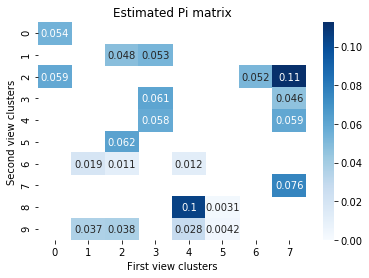

In [8]:
# specify the view mixture models
base_gmm_params = {'covariance_type': 'diag', 'reg_covar': 1e-6}
base_view_models = [GaussianMixture(n_components=n_view_components[v],
                                    **base_gmm_params) for v in range(2)]

# the penalty value should be in [0, 1/np.product(n_view_components))
pen = .1/  np.product(n_view_components)

mvmm = LogPenMVMM(base_view_models=base_view_models, pen=pen)
mvmm.fit(view_data)

print('Estimated number of components', mvmm.n_components)

# plot the estimated Pi matrix
Pi_est = mvmm.weights_mat_
sns.heatmap(Pi_est.T,  # transpose so the first view is on the rows
            annot=True, cmap='Blues', vmin=0, mask=Pi_est.T == 0)
plt.xlabel("First view clusters")
plt.ylabel("Second view clusters")
plt.title("Estimated Pi matrix")

# initialize the log-penalized MVMM from the basic MVMM

Estimated number of components 19


Text(0.5, 1, 'Estimated Pi matrix')

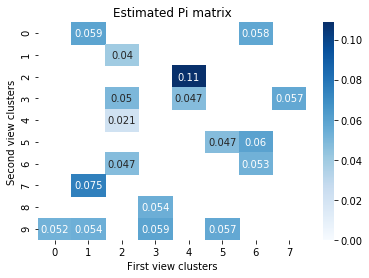

In [5]:
# setup view mixture models
base_view_models = [GaussianMixture(n_components=n_view_components[v],
                                    **base_gmm_params) for v in range(2)]

# setup starting MVMM
base_start = MVMM(base_view_models=base_view_models)

# setup final log-pen MVMM
base_final = LogPenMVMM(base_view_models=base_view_models, pen=pen)

# setup and fit two stage mixture model
two_stage = TwoStage(base_start=base_start, base_final=base_final,
                     n_init=10, random_state=9248)
two_stage.fit(view_data)


print('Estimated number of components', mvmm.n_components)

# plot the estimated Pi matrix
Pi_est = two_stage.final_.weights_mat_
sns.heatmap(Pi_est.T,  # transpose so the first view is on the rows
            annot=True, cmap='Blues', vmin=0, mask=Pi_est.T == 0)
plt.xlabel("First view clusters")
plt.ylabel("Second view clusters")
plt.title("Estimated Pi matrix")

# grid search over range of penalty values

In [9]:
# view mixture models
base_view_models = [GaussianMixture(n_components=n_view_components[v],
                                    **base_gmm_params) for v in range(2)]

# initialize with a few EM iterations of the MVMM
base_start = MVMM(base_view_models=base_view_models, max_n_steps=10)

# log pen MVMM
base_final = LogPenMVMM(base_view_models=base_view_models)

# base two stage estimator
base_estimator = TwoStage(n_init=1,
                          base_start=base_start, base_final=base_final,
                          random_state=234)

# setup penalty sequence
# mult values should be between 0 and 1
# we use quadratic spacing meaning there are more small penalty values (meaning fewer zeros)
mult_vals = unit_intval_polyspace(num=50, deg=2)
param_grid = {'pen': mult_vals / np.product(n_view_components)}

grid_search = MVMMGridSearch(base_estimator=base_estimator,
                             param_grid=param_grid,
                             n_jobs=-1) # parallelize the grid search


grid_search.fit(view_data)

MVMMGridSearch(base_estimator=TwoStage(base_final=LogPenMVMM(abs_tol=1e-09,
                                                             base_view_models=[GaussianMixture(abs_tol=1e-09,
                                                                                               covariance_type='diag',
                                                                                               history_tracking=0,
                                                                                               init_params_method='kmeans',
                                                                                               init_params_value=None,
                                                                                               init_weights_method='uniform',
                                                                                               init_weights_value=None,
                                                                                           

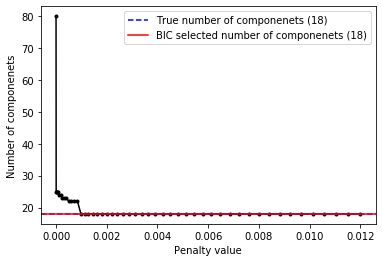

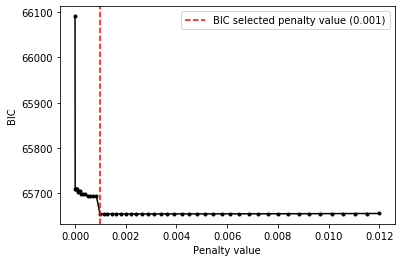

In [10]:
n_comp_est = [est.final_.n_components for est in grid_search.estimators_]
pen_vals = [est.final_.pen for est in grid_search.estimators_]
bic_vals = grid_search.model_sel_scores_['bic']

sel_n_comp = n_comp_est[grid_search.best_idx_]
sel_pen = pen_vals[grid_search.best_idx_]

plt.figure()
plt.plot(pen_vals, n_comp_est, marker='.', color='black')
plt.xlabel("Penalty value")
plt.ylabel("Number of componenets")
plt.axhline(n_comp_true, label='True number of componenets ({})'.format(n_comp_true), 
            color='blue', ls='--')

plt.axhline(sel_n_comp, label='BIC selected number of componenets ({})'.format(sel_n_comp), 
            color='red', ls='-')

plt.legend()


plt.figure()
plt.plot(pen_vals, bic_vals, marker='.', color='black')
plt.xlabel("Penalty value")
plt.ylabel("BIC")
plt.axvline(sel_pen, label='BIC selected penalty value ({:1.3f})'.format(sel_pen), 
            color='red', ls='--')
plt.legend()
